# Time Series Intro

The study of time series has arisen because certain sorts of data streams are heavily dependent on the flow of time. Of course, we have not totally ignored time as a feature up to this point. The selling price of a house probably *does* have some relation to the season or the year as real estate markets grow and decline with certain temporally-indexed economic changes etc. But surely time is not the most important predictor of house price. Square footage would likely be more strongly correlated with price than would date of sale.

But there are other sorts of data that more readily lend themselves to a temporal analysis. One canonical example is numbers from a stock exchange: First, data from stock tickers often arrive as numbers anchored to consecutive units of time. I get the selling price for some stock on January 1, say, and the next bit of information I gain will be the selling price for that stock on January 2. (We'll explore this feature of time series below.) Second, and more important, if I'm interested in actually *predicting* the selling price of a stock for, say, tomorrow, then very likely one piece of very salient (i.e. *correlated*) information would be the selling price of that stock *today*.

What other examples of this sort of time-dependent data can you think of?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [2]:
pd.read_csv('data/google-trends_game-of-thrones_us.csv').head()

,Category: All categories
Month,"""game of thrones"": (United States)"
2004-01,<1
2004-02,<1
2004-03,<1
2004-04,<1


In [3]:
!ls data

google-trends_data-science_us.csv
google-trends_football_uk.csv
google-trends_football_us.csv
google-trends_game-of-thrones_us.csv
google-trends_pokemon_us.csv
google-trends_taxes_us.csv
seasonally-adjusted-quarterly-us.csv


In [4]:
# Define a function that will help us load and
# clean up a dataset.

def load_trend(trend_name='football', country_code='us'):
    df = pd.read_csv('data/google-trends_'
                     + trend_name + '_'
                     + country_code
                     + '.csv').iloc[1:, :]
    df.columns = ['counts']
    df['counts'] = df['counts'].str.replace('<1', '0').astype(int)
    return df

In [5]:
df = load_trend(**{'trend_name': 'data-science', 'country_code': 'us'})

In [6]:
df

,counts
2004-01,2
2004-02,1
2004-03,0
2004-04,1
2004-05,0
...,...
2019-01,98
2019-02,96
2019-03,97
2019-04,100


In [7]:
trends = [
    {'trend_name': 'data-science', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'uk'},
    {'trend_name': 'game-of-thrones', 'country_code': 'us'},
    {'trend_name': 'pokemon', 'country_code': 'us'},
    {'trend_name': 'taxes', 'country_code': 'us'},   
]

In [8]:
np.random.shuffle(trends)

In [9]:
trend_dfs = [load_trend(**trend) for trend in trends]

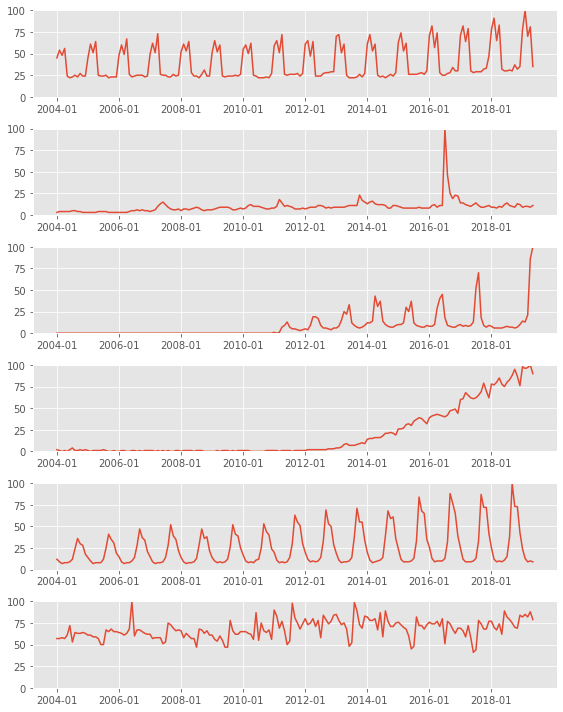

In [10]:
# Let's see if we can guess which is which just by looking
# at their graphs.

import matplotlib; matplotlib.style.use('ggplot')

fig, axs = plt.subplots(len(trend_dfs), 1, figsize=(8, 10))
plt.tight_layout()
for i, trend_df in enumerate(trend_dfs):
    ax = axs[i]
    #ax.set_title(str(trends[i]))
    ax.plot(np.array(trend_df.index), trend_df['counts'])
    ticks = ax.get_xticks()
    ax.set_ylim((0, 100))
    ax.set_xticks([tick for tick in ticks if tick%24 == 0])

We could do a histogram of our data, say of the taxes counts:

In [11]:
taxes_df = load_trend('taxes')

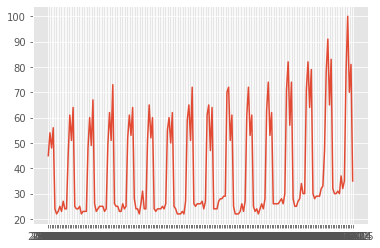

In [12]:
plt.plot(np.array(taxes_df.index), taxes_df['counts'])

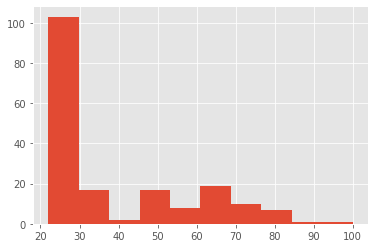

In [13]:
plt.hist(taxes_df['counts']);

But clearly we would be missing something important about how the data is structured. Let's try to capture that. We'll stick with the taxes data.

In [14]:
# Adding a month column

taxes_df['i'] = np.arange(len(taxes_df))
taxes_df['month'] = taxes_df['i'] % 12

In [15]:
# Using month to predict tax activity

trend_model = LinearRegression()
trend_model.fit(taxes_df[['i']], taxes_df['counts'])
trend_line = trend_model.predict(taxes_df[['i']])

In [16]:
trend_line[:12]

array([31.65754141, 31.73558811, 31.81363481, 31.89168151, 31.96972821,
       32.04777491, 32.12582161, 32.20386831, 32.28191501, 32.35996171,
       32.43800842, 32.51605512])

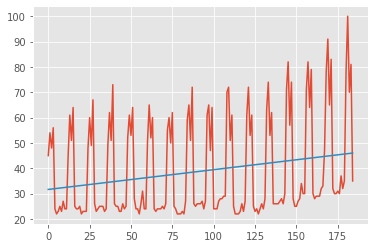

In [17]:
plt.plot(taxes_df['i'], taxes_df['counts'])
plt.plot(taxes_df['i'], trend_line);

Clearly, this model leaves something to be desired! Let's try again. And this time we'll make explicit use of the time indices.

In [18]:
month_encoder = OneHotEncoder(categories='auto')
month_encoder.fit(taxes_df[['month']])
month_data = month_encoder.transform(taxes_df[['month']]).toarray()

In [19]:
month_data[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
lr = LinearRegression()

In [21]:
data = np.hstack((taxes_df[['i']].values, month_data))

In [22]:
data[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
lr.fit(data, taxes_df['counts'])
lr_pred = lr.predict(data)  # Predictive model based on i and month

In [24]:
lr_pred[:12]

array([52.63422131, 63.19672131, 46.88422131, 60.50922131, 19.63422131,
       17.83360656, 18.10027322, 18.36693989, 18.63360656, 21.16693989,
       18.96693989, 21.70027322])

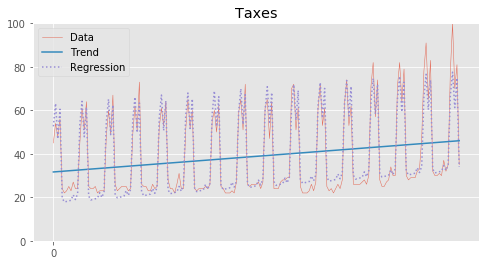

In [25]:
trend_df = taxes_df
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Taxes')
ax.plot(trend_df['i'], trend_df['counts'], label='Data',
       linewidth=.5, alpha=.8)
ax.plot(trend_df['i'], trend_line, label='Trend')
ax.plot(trend_df['i'], lr_pred, label='Regression', linestyle="dotted")
plt.legend()
ticks = ax.get_xticks()
ax.set_ylim((0, 100))
ax.set_xticks([tick for tick in ticks if tick%24 == 0])
plt.show()

In [ ]:
residuals = trend_df['counts'] - lr_pred

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Residuals")
ax.plot(trend_df['i'], trend_df['counts'], label='Data',
       linewidth=.5, alpha=.8)
ax.plot(trend_df['i'], lr_pred, label='Regression', linestyle="dotted")
ax.plot(trend_df['i'], residuals,
        label='Residuals', linewidth=.5)

#ax.plot(trend_df.index, trend_line, label='trend')
plt.legend()
ticks = ax.get_xticks()
ax.set_ylim((-10, 90))
ax.set_xticks([tick for tick in ticks if tick%24 == 0])
plt.show()

## Datetime Objects

These comprise a nice standard way of dealing with times and dates in Python. There is a `datetime` [library](https://docs.python.org/2/library/datetime.html), and inside `pandas` there is a `datetime` module as well as a `to_datetime()` function.

In [ ]:
import datetime

In [ ]:
datetime.datetime(2020, 12, 31)

### Datetime objects have the parts of a date as attributes

In [ ]:
now = datetime.datetime(2020, 12, 31)

In [ ]:
now.year

In [ ]:
now.month

In [ ]:
now.day

In [ ]:
now.hour

### `.timedelta()`

In [ ]:
moment = datetime.timedelta(minutes=100)
moment.days

In [ ]:
moment.seconds

In [ ]:
pd.to_datetime(100)

In [ ]:
pd.to_datetime('2020-12-31')

In [ ]:
pd.to_datetime(['2020-12-30', '2020-12-31'], format='%Y-%m-%d')

There are [many](https://docs.python.org/2/library/datetime.html) format codes that `datetime` supports.

## Upsampling and Downsampling

Sometimes we have information sorted according to a certain level in the temporal hierarchy but we'd like to have it sorted according to a different level. For example, we have monthly data but we want to look at quarters, or we have daily data but we want to visualize hourly trends.

**To upsample** is to *increase the frequency* of the data of interest. <br/>
**To downsample** is to *decrease the frequency* of the data of interest.

There is a `.resample()` method available for `pandas` objects:

In [26]:
times = np.arange(10)
np.random.seed(42)
target = np.random.random(size=10)

In [27]:
rev_times = pd.to_datetime(times, format='%M')
rev_times

DatetimeIndex(['1900-01-01 00:00:00', '1900-01-01 00:01:00',
               '1900-01-01 00:02:00', '1900-01-01 00:03:00',
               '1900-01-01 00:04:00', '1900-01-01 00:05:00',
               '1900-01-01 00:06:00', '1900-01-01 00:07:00',
               '1900-01-01 00:08:00', '1900-01-01 00:09:00'],
              dtype='datetime64[ns]', freq=None)

In [28]:
df = pd.DataFrame({'target': target}, index=rev_times)
df

,target
1900-01-01 00:00:00,0.374540
1900-01-01 00:01:00,0.950714
1900-01-01 00:02:00,0.731994
1900-01-01 00:03:00,0.598658
1900-01-01 00:04:00,0.156019
1900-01-01 00:05:00,0.155995
1900-01-01 00:06:00,0.058084
1900-01-01 00:07:00,0.866176
1900-01-01 00:08:00,0.601115
1900-01-01 00:09:00,0.708073


### Upsampling with `.resample()`

In [29]:
df.resample('S')

#### `.ffil()`

In [30]:
df_up = df.resample('S').ffill()

In [31]:
df_up.head()

,target
1900-01-01 00:00:00,0.37454
1900-01-01 00:00:01,0.37454
1900-01-01 00:00:02,0.37454
1900-01-01 00:00:03,0.37454
1900-01-01 00:00:04,0.37454


#### `.bfill()`

In [32]:
df_up = df.resample('S').bfill()
df_up.head()

,target
1900-01-01 00:00:00,0.374540
1900-01-01 00:00:01,0.950714
1900-01-01 00:00:02,0.950714
1900-01-01 00:00:03,0.950714
1900-01-01 00:00:04,0.950714


#### `.interpolate()`

In [33]:
df_up = df.resample('S').interpolate()
df_up.head()

,target
1900-01-01 00:00:00,0.374540
1900-01-01 00:00:01,0.384143
1900-01-01 00:00:02,0.393746
1900-01-01 00:00:03,0.403349
1900-01-01 00:00:04,0.412952


In [34]:
(df_up.iloc[60,] - df_up.iloc[0,]) / 60

target    0.009603
dtype: float64

In [35]:
[df_up.iloc[j+1,].values - df_up.iloc[j,].values for j in range(59)][:10]

[array([0.0096029]),
 array([0.0096029]),
 array([0.0096029]),
 array([0.0096029]),
 array([0.0096029]),
 array([0.0096029]),
 array([0.0096029]),
 array([0.0096029]),
 array([0.0096029]),
 array([0.0096029])]

### Downsampling with `.resample()`

In [36]:
df.resample('h')

In [37]:
df_down = df.resample('h').ffill()

In [39]:
df_down

,target
1900-01-01,0.37454


[Here](https://machinelearningmastery.com/resample-interpolate-time-series-data-python/) is a helpful post on this sort of resampling in Python.

## Decomposing a Time Series

Statsmodels has a great tool for looking at a time series as a sum of parts: a general trend, a seasonality component, and whatever is left over (often called a residual (why?)): its `seasonal_decompose()` function.

In [40]:
taxes_df.index = pd.to_datetime(taxes_df.index)

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(taxes_df['counts'])

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [42]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

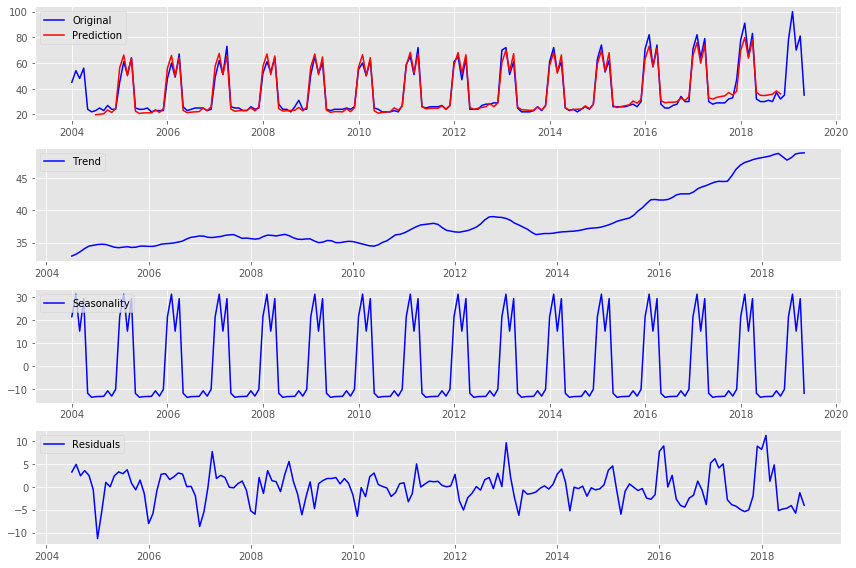

In [45]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.plot(trend+seasonal, label='Prediction', color="red")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

Exercise to make sure that the residual really captures *all* remaining information about our times series.

For various techincal reasons that won't concern us here, some of the components of the decomposition have NANs at their heads and tails. But we can just use `np.nansum()`.

# GOT example

In [49]:
got.index = pd.to_datetime(got.index)

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(got['counts'])

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [51]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

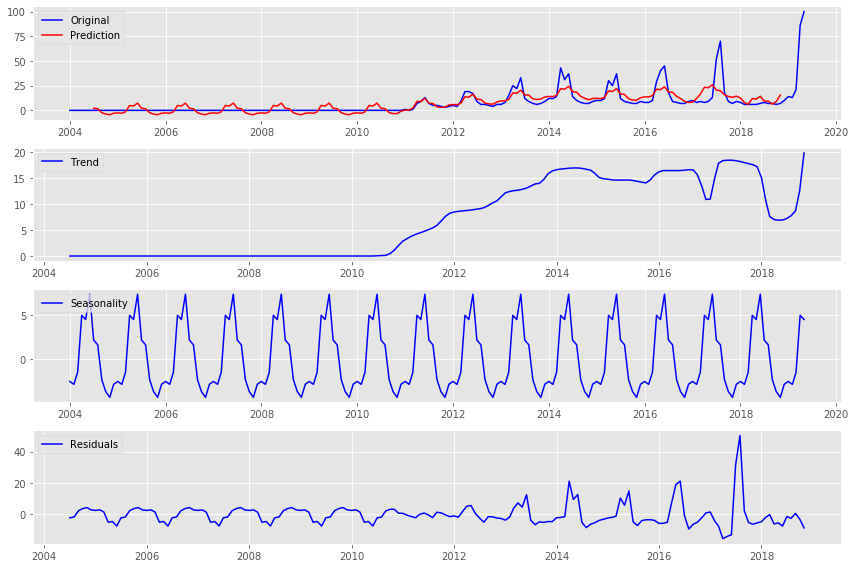

In [52]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.plot(trend+seasonal, label='Prediction', color="red")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

In [ ]:
trend.head()

In [ ]:
myst = 0
for i in range(len(taxes_df['counts'])):
    myst += np.nansum(taxes_df['counts'][i] - trend[i] - seasonal[i] - residual[i])
myst

In [46]:
got = load_trend('game-of-thrones','us')

In [47]:
got

,counts
2004-01,0
2004-02,0
2004-03,0
2004-04,0
2004-05,0
...,...
2019-01,14
2019-02,13
2019-03,21
2019-04,86


# Extra Resources for timeseries manipulation

- [Aileen Neilsen SciPy - 2016](https://www.youtube.com/watch?v=JNfxr4BQrLk)

- [Aileen Neilsen - Github](https://github.com/AileenNielsen/TimeSeriesAnalysisWithPython)

- [A project on Flight Fares](https://achyutjoshi.github.io/btp/datacollection)

- [Python DS Handbook - Working with TS](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)